In [ ]:
#import drive to handle the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os # to handle files from drive
import pandas as pd # for reading and handling data
import openai # for using GPT API
import tiktoken as tokens #for counting the tokens
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix #matrices for evaluation
import matplotlib.pyplot as plt #for graphs
import seaborn as sns #for graphs too
import numpy as np # for numerical operations
from scipy import signal # for signal processing (FFT, filters)

In [ ]:
#API Key to link the model with the code
openai.api_key = "sk-proj-waN-w9vmtaUgdk0mPXvo5r4XVyKutHej_XNL_Iw9L-5pZgLR8nxCHuXJ4oz0g4cl0tcHN4FERMT3BlbkFJby3xJnSZGm85O8rggsk6zr47YIdaBD4KUvbWF7QY180R2rX5G6nJgdCs5lve2-SQMyKmPq2N4"

In [ ]:
# load the data from drive
file_path = '/content/drive/MyDrive/hhar_merged_half.csv'
data_set = pd.read_csv(file_path)

In [ ]:
# we did this step when we merge the data but for ensure
data_set = data_set.dropna()
allowed_activities = ['stand', 'sit', 'bike', 'walk']
data_set = data_set[data_set['gt'].isin(allowed_activities)]

In [ ]:
#show the balance of the selected activities
activity_counts = data_set['gt'].value_counts()
print("Activity counts:\n", activity_counts)
balance_ratio = activity_counts.min() / activity_counts.max()
print("Balance ratio:", balance_ratio)

Activity counts:
 gt
walk     141672
sit      128915
stand    113094
bike     104706
Name: count, dtype: int64
Balance ratio: 0.7390733525326105


In [ ]:
# prepare the values for the window
sample_rate = 50 #hz
window_duration = 2.56 #s
window_size = int(sample_rate * window_duration)  # number of rows per window
overlap = window_size #0% overlapping

axis_cols = ['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z']  # sensors columns

In [ ]:
# calculating dominant frequency of a signal
def dominant_frequency(signal_mag, fs):
    sig = signal_mag - np.mean(signal_mag) # remove the mean for a cleaner FFT
    if np.allclose(sig, 0): # check values is 0 frequency cant be computed
        return 0.0
    freqs = np.fft.rfftfreq(len(sig), d=1.0/fs) # only get the positive side - time step between samples
    fft = np.abs(np.fft.rfft(sig)) # gets how strong each frequency is
    if fft.size == 0: # ensures no errors
        return 0.0
    return float(freqs[np.argmax(fft)]) #print the index of highest peak in the FFT and converts it to float

In [ ]:
# extract 6 features from acc and gyro data
def extract_six_features(x_acc, y_acc, z_acc, x_gyro, y_gyro, z_gyro, fs=50):

    # Compute magnitude of acceleration and gyroscope
    mag_acc = np.sqrt(x_acc**2 + y_acc**2 + z_acc**2)
    mag_gyro = np.sqrt(x_gyro**2 + y_gyro**2 + z_gyro**2)


    #Extract 6 statistical features
    mean_acc_mag = float(np.mean(mag_acc)) #mean acceleration magnitude
    std_acc_mag  = float(np.std(mag_acc))     #standard deviation of acceleration magnitude
    p2p_acc_mag  = float(np.ptp(mag_acc))   #peak-to-peak acceleration magnitude
    domfreq_acc  = float(dominant_frequency(mag_acc, fs))    #dominant frequency of acceleration magnitude
    mean_gyro_mag = float(np.mean(mag_gyro))   #mean angular velocity magnitude
    std_gyro_mag  = float(np.std(mag_gyro))    #std of angular velocity magnitude



    return {
        "mean_acc_mag": mean_acc_mag,
        "std_acc_mag": std_acc_mag,
        "p2p_acc_mag": p2p_acc_mag,
        "domfreq_acc": domfreq_acc,
        "mean_gyro_mag": mean_gyro_mag,
        "std_gyro_mag": std_gyro_mag
    }

In [ ]:
# set the window
windows = []  # to store all windows
true_labels = []  # to store the true labels

for i in range(0, len(data_set) - window_size + 1, overlap): # loop through the dataset
    window = data_set.iloc[i:i + window_size]  # select window slice

    # Compute 6 features for this window
    features = extract_six_features(
        window['acc_x'].to_numpy(dtype=float),
        window['acc_y'].to_numpy(dtype=float),
        window['acc_z'].to_numpy(dtype=float),
        window['gyro_x'].to_numpy(dtype=float),
        window['gyro_y'].to_numpy(dtype=float),
        window['gyro_z'].to_numpy(dtype=float),
        sample_rate
    )
    windows.append(features) #add the window and label

    # the most frequent label is the true label
    label = window['gt'].mode()[0]
    true_labels.append(label)

# count the number of windows created
num_windows = len(windows)
print(f"Number of windows: {num_windows}")

# Save the values calculated from the sensor signals
window_csv = "/content/drive/MyDrive/features6_per_window.csv"
pd.DataFrame(windows).to_csv(window_csv, index=False)


Number of windows: 3815


In [ ]:
# make prompt
def make_feature_prompt(feat):
    categories = ", ".join(allowed_activities)
    prompt = f"""
### Instruction:
You are an expert in IMU-based human activity analysis.
Data Description: You will be given a set of features extracted from a window of IMU data that included: `accelerometer_x`, `accelerometer_y`, `accelerometer_z`: Acceleration values in m/s².
-   `gyroscope_x`, `gyroscope_y`, `gyroscope_z`: Angular velocity values in rad/s. The IMU data was collected from a mobile phone attached to the user's body with a sampling rate of 50 Hz.

The following six features have been extracted from the IMU data:

1-  Mean acceleration magnitude: {feat['mean_acc_mag']}

2-  Standard deviation of acceleration magnitude: {feat['std_acc_mag']}

3-  Peak-to-peak acceleration magnitude: {feat['p2p_acc_mag']}

4-  Dominant frequency of acceleration magnitude: {feat['domfreq_acc']}

5-  Mean angular velocity magnitude: {feat['mean_gyro_mag']}

6-  Standard deviation of angular velocity magnitude: {feat['std_gyro_mag']}

The person's action belongs to one of the following categories: [{categories}].
Task: Based on the provided feature values, choose only one action from {categories} that best represents the person’s activity.
Answer with one word only — the chosen category.

### Response:
"""
    return prompt

In [ ]:
# count the tokens for each window
def count_tokens(text, model="gpt-5"):
    encoding = tokens.encoding_for_model(model)
    encoded_tokens = encoding.encode(text)
    return len(encoded_tokens)

In [ ]:
# classify a single window
def classify_window(window_values):
    prompt = make_feature_prompt(window_values)

    #count the number of tokens before the submit
    num_tokens = count_tokens(prompt)

    try:
        response = openai.chat.completions.create(
            model="gpt-5",
            messages=[{"role": "user", "content": prompt}]
        )
        label = response.choices[0].message.content.strip()

        output_tokens = count_tokens(label) # counts the output tokens

        return label,  num_tokens, output_tokens
    except Exception as e:
        print(f"API Error: {e}")
        return "unknown", num_tokens


In [ ]:
#implemntation

predictions_csv = "/content/drive/MyDrive/predictions_from6features.csv"

if os.path.exists(predictions_csv): #if the file already exits complete the process
    readTheFile = pd.read_csv(predictions_csv)
    start_index = len(readTheFile)
    pred_labels = readTheFile["prediction"].tolist()
    all_tokens = readTheFile["num_tokens"].tolist()
    print(f"Resuming from index {start_index}")
else: #or start form the begining

    start_index = 0
    pred_labels = []
    all_tokens = []
    print("Starting  predictions:")

batch_size = 50 #number of windows each batch


for i in range(start_index, len(windows), batch_size):
    batch_windows = windows[i:i+batch_size]

    # label and tokens for each window
    batch_preds = []
    batch_tokens = []

    for w in batch_windows:
        label, tokens_count = classify_window(w)
        batch_preds.append(label)
        batch_tokens.append(tokens_count)

    pred_labels.extend(batch_preds)
    all_tokens.extend(batch_tokens)

    header = not os.path.exists(predictions_csv) and i == 0
    pd.DataFrame({"window_values": batch_windows, "prediction": batch_preds , "num_tokens": batch_tokens}).to_csv(
        predictions_csv, mode="a", header=header, index=False
    )
    print(f"Processed batch {i} to {i+len(batch_windows)}, tokens per window: {batch_tokens}")



Resuming from index 3814
API Error: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable
Processed batch 3814 to 3815, tokens per window: [293]


In [ ]:
# evaluation
results = pd.read_csv(predictions_csv)

# take the true labels(array true label above) with the predections of the model
pred_labels = results["prediction"].tolist()

# make sure same length for true and predicted labels
n = min(len(true_labels), len(pred_labels))
y_true = true_labels[:n]
y_pred = pred_labels[:n]

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, labels=allowed_activities, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, labels=allowed_activities, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, labels=allowed_activities, average='weighted', zero_division=0)
cm = confusion_matrix(y_true, y_pred, labels=allowed_activities)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(pd.DataFrame(cm, index=allowed_activities, columns=allowed_activities))
average_output_tokens = results["output_tokens"].mean()
total_output_tokens = results["output_tokens"].sum()

print("Average output tokens per window:", average_output_tokens)
print("Total output tokens:", total_output_tokens)


Accuracy: 0.3717
Precision (weighted): 0.4609
Recall (weighted): 0.3717
F1 (weighted): 0.3371
Confusion Matrix:
       stand  sit  bike  walk
stand    407   86   351    38
sit      520  111   338    39
bike       5    0   642   171
walk       1    0   847   258
Average output tokens per window: 1.0
Total output tokens: 3814.0


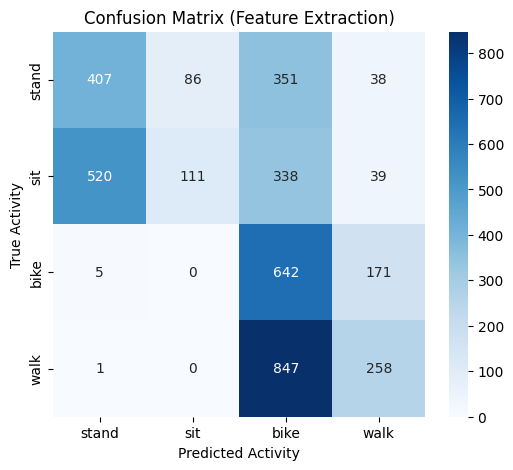

In [ ]:
# gragh for confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=allowed_activities,
            yticklabels=allowed_activities)
plt.xlabel("Predicted Activity")
plt.ylabel("True Activity")
plt.title("Confusion Matrix (Feature Extraction)")
plt.show()

In [ ]:
#count the averge of tokens per window and the total
average_tokens = results["num_tokens"].mean()
total_tokens = results["num_tokens"].sum()

print("Average tokens per window:", average_tokens)
print("Total tokens used:", total_tokens)

Average tokens per window: 296.1328964613368
Total tokens used: 1129747


In [ ]:
#show the labels for all window in true-labels and prediction

final_file = "/content/drive/MyDrive/trueLabels_predictions_from6features.csv"
results = pd.read_csv(final_file)
true_labels = results["true_label"].tolist()
pred_labels = results["pred_label"].tolist()


def get_activity_segments(labels):
    """
    Returns segments formatted as:
    [(start_index, end_index, activity), ...]
    """
    segments = [] #to store all segments
    start = 0 # start point for each segments
    current = labels[0]

    for i in range(1, len(labels)):
        if labels[i] != current: #if the current activity is not the same activity in the true and preditction windows
            segments.append((start, i - 1, current)) #add the segmants to the array
            start = i #change the start of the next segments
            current = labels[i] #change the activity to the next one

    segments.append((start, len(labels) - 1, current)) #loop to add more the last segment for each activity
    return segments


true_segments = get_activity_segments(true_labels)
pred_segments = get_activity_segments(pred_labels)

print("\n True Activity Segments ")
for seg in true_segments:
    print(f"From window {seg[0]} to {seg[1]} → {seg[2]}")

print("\nPredi cted Activity Segments ")
for seg in pred_segments:
    print(f"From window {seg[0]} to {seg[1]} → {seg[2]}")



 True Activity Segments 
From window 0 to 78 → bike
From window 79 to 210 → sit
From window 211 to 326 → stand
From window 327 to 433 → walk
From window 434 to 556 → bike
From window 557 to 644 → sit
From window 645 to 730 → stand
From window 731 to 866 → walk
From window 867 to 934 → bike
From window 935 to 1043 → sit
From window 1044 to 1129 → stand
From window 1130 to 1247 → walk
From window 1248 to 1328 → bike
From window 1329 to 1437 → sit
From window 1438 to 1548 → stand
From window 1549 to 1681 → walk
From window 1682 to 1792 → bike
From window 1793 to 1908 → sit
From window 1909 to 2019 → stand
From window 2020 to 2156 → walk
From window 2157 to 2236 → bike
From window 2237 to 2317 → sit
From window 2318 to 2395 → stand
From window 2396 to 2493 → walk
From window 2494 to 2575 → bike
From window 2576 to 2694 → sit
From window 2695 to 2802 → stand
From window 2803 to 2939 → walk
From window 2940 to 3024 → bike
From window 3025 to 3155 → sit
From window 3156 to 3235 → stand
From 

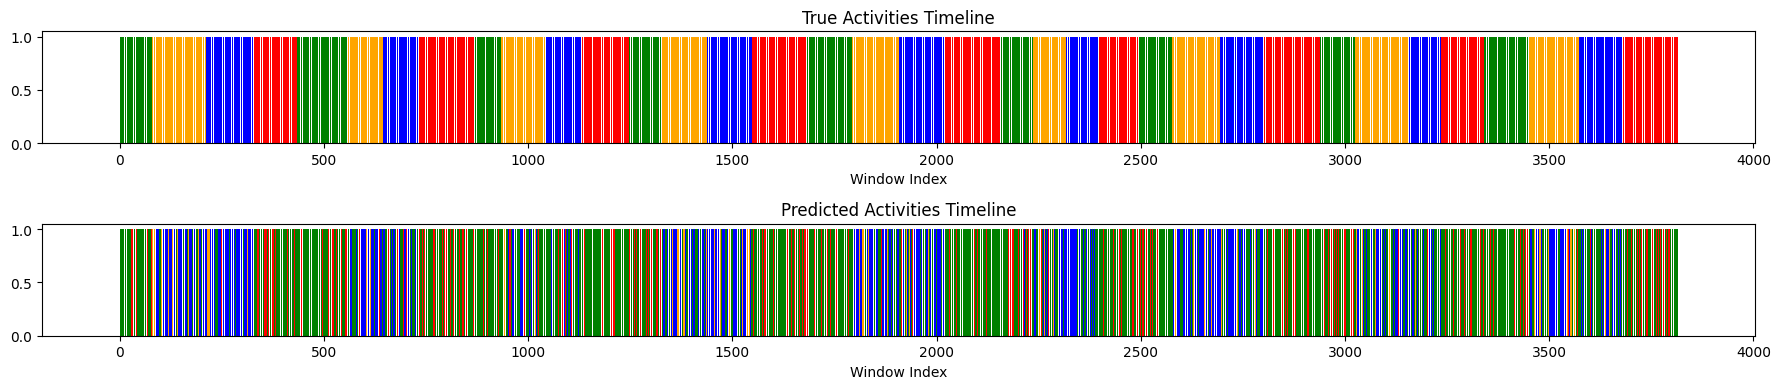

In [ ]:
#timeline gragh for the segments of windows (true labels - presctions )

activities = ['stand', 'sit', 'bike', 'walk']
colors = {
    'stand': 'blue',
    'sit': 'orange',
    'bike': 'green',
    'walk': 'red',
    None: 'gray'
}


pred_labels = [p if p in activities else None for p in pred_labels] #for unknown predection


plt.figure(figsize=(18, 4))


plt.subplot(2, 1, 1)
i = 0
for activity in true_labels:
    plt.bar(i, 1, color=colors[activity])
    i += 1

plt.title("True Activities Timeline")
plt.xlabel("Window Index")

plt.subplot(2, 1, 2)
i = 0
for activity in pred_labels:
    plt.bar(i, 1, color=colors[activity])
    i += 1

plt.title("Predicted Activities Timeline")
plt.xlabel("Window Index")

plt.tight_layout() #make the the graphs coherent
plt.show()